## Image Classification with resnet50 model

In this notebook, we are going to demonstrate how **IPEX** can be used for **resnet50** model training in PyTorch framework. For any other PyTorch model, same process can be followed to leverage IPEX optimizations. 

In this example we will be classifying the image into **Alien** and **Predator** using a CNN based image classification model resnet50. Dataset contains 347 input training images per class and 100 test images for each class.
Dataset and base notebook is taken from  is taken from https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-pytorch 

<table><tr><td><img src='data/train/alien/259.jpg'></td><td><img src='data/train/alien/171.jpg'></td><td><img src='data/train/predator/303.jpg'></td><td><img src='data/validation/predator/75.jpg'></td></tr></table>

### 1. Import dependencies

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import time

In [2]:
import torch
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import intel_pytorch_extension as ipex

### 2. Create PyTorch data generators

In [28]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder('data/validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False)
}

### 3. Create the network

In [29]:
model = models.resnet50(pretrained=True)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2))


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [31]:
device = torch.device("cpu")
print(device)

cpu


### 4. Train the model

In [32]:
def train_model(model, criterion, optimizer, num_epochs=3, IPEX=False):
    since= time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                if IPEX:
                    model = model.to(ipex.DEVICE)
                    inputs = inputs.to(ipex.DEVICE)
                    labels = labels.to(ipex.DEVICE)
                else:
                    model =  model.to(device)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f} \n'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    time_elapsed = time.time() - since
    train_model.ttime= time_elapsed
    print('Training completed in {:.0f}m {:.0f}s \n \n'.format(time_elapsed // 60, time_elapsed % 60))
    return model

pytorch version: 1.7.0a0+e85d494
ipex version：   1.2.0
Training with normal PyTorch
Epoch 1/3
----------
train loss: 0.4968, acc: 0.7779 

validation loss: 0.2904, acc: 0.8800 

Epoch 2/3
----------
train loss: 0.2583, acc: 0.9019 

validation loss: 0.2192, acc: 0.9250 

Epoch 3/3
----------
train loss: 0.1591, acc: 0.9414 

validation loss: 0.2170, acc: 0.9150 

Training completed in 2m 11s 
 

Training with Intel Extension for PyTorch (IPEX)
Epoch 1/3
----------
train loss: 0.1468, acc: 0.9360 

validation loss: 0.1968, acc: 0.9250 

Epoch 2/3
----------
train loss: 0.1192, acc: 0.9496 

validation loss: 0.3433, acc: 0.8450 

Epoch 3/3
----------
train loss: 0.1234, acc: 0.9537 

validation loss: 0.2082, acc: 0.9150 

Training completed in 1m 19s 
 

Training time (normal): 131.06sec
Training time (ipex):   78.89sec
IPEX achieved 39.81% better performance comparing to normal PyTorch, Speed up of 1.66x


<BarContainer object of 2 artists>

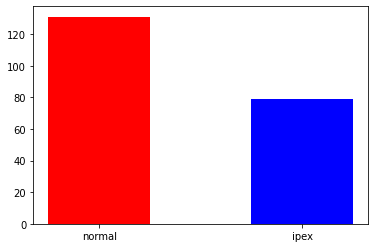

In [33]:
print("pytorch version: {}".format(torch.__version__))
print("ipex version：   {}".format(ipex.__version__))
print("Training with normal PyTorch")
model_trained = train_model(model, criterion, optimizer, num_epochs=3, IPEX=False)
dur_n = train_model.ttime
print("Training with Intel Extension for PyTorch (IPEX)")
model_trained = train_model(model, criterion, optimizer, num_epochs=3, IPEX=True)
dur_i = train_model.ttime
print('Training time (normal): {:.2f}sec'.format(dur_n))
print('Training time (ipex):   {:.2f}sec'.format(dur_i))
print('IPEX achieved {:.2f}% better performance comparing to normal PyTorch, Speed up of {:.2f}x'.format((dur_n-dur_i)/dur_n*100, dur_n/dur_i))

plt.bar(["normal", "ipex"], [dur_n, dur_i], width=0.5 , color = ['red' , 'blue'])

In [34]:
def infer_model(model, IPEX=False):
    since= time.time()
    
    model.eval()
                
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['validation']:
        if IPEX:
            model = model.to(ipex.DEVICE)
            inputs = inputs.to(ipex.DEVICE)
            labels = labels.to(ipex.DEVICE)
        else:
            model =  model.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)    

        outputs = model(inputs)
        loss = criterion(outputs, labels)


        _, preds = torch.max(outputs, 1)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(image_datasets['validation'])
    epoch_acc = running_corrects.float() / len(image_datasets['validation'])

    print('validation loss: {:.4f}, acc: {:.4f}'.format(epoch_loss.item(),epoch_acc.item()))
            
    time_elapsed = time.time() - since
    print('Inference completed in {:.0f}m {:.0f}s \n \n'.format(time_elapsed // 60, time_elapsed % 60))
    return time_elapsed

pytorch version: 1.7.0a0+e85d494
ipex version：   1.2.0
Inference with normal PyTorch
validation loss: 0.2082, acc: 0.9150
Inference completed in 0m 12s 
 

Inference with Intel Extension for PyTorch (IPEX)
validation loss: 0.2082, acc: 0.9150
Inference completed in 0m 5s 
 

Inference time (normal): 11.91sec
Inference time (ipex):   5.23sec
IPEX achieved 56.12% better performance comparing to normal PyTorch, Speed up of 2.28x


<BarContainer object of 2 artists>

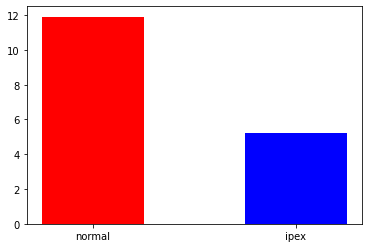

In [35]:
print("pytorch version: {}".format(torch.__version__))
print("ipex version：   {}".format(ipex.__version__))
print("Inference with normal PyTorch")
dur_n = infer_model(model_trained, IPEX=False)
print("Inference with Intel Extension for PyTorch (IPEX)")
dur_i = infer_model(model_trained, IPEX=True)
print('Inference time (normal): {:.2f}sec'.format(dur_n))
print('Inference time (ipex):   {:.2f}sec'.format(dur_i))
print('IPEX achieved {:.2f}% better performance comparing to normal PyTorch, Speed up of {:.2f}x'.format((dur_n-dur_i)/dur_n*100, dur_n/dur_i))

plt.bar(["normal", "ipex"], [dur_n, dur_i], width=0.5 , color = ['red' , 'blue'])

### 6. Make predictions on sample test images

In [36]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [37]:
validation_batch = torch.stack([data_transforms['validation'](img).to(ipex.DEVICE)
                                for img in img_list])

In [38]:
pred_logits_tensor = model_trained(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

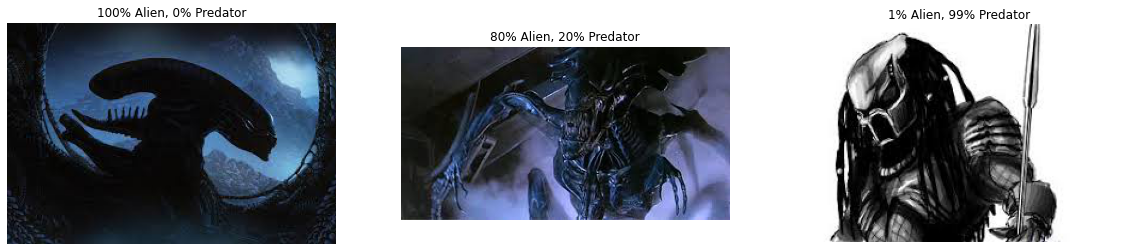

In [39]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)